In [1]:
'''
author: Yike Xie
data: 5/9/2023
content: correlate image features and exon transcriptome
'''

'\nauthor: Yike Xie\ndata: 5/9/2023\ncontent: correlate image features and exon transcriptome\n'

In [2]:
import os
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scanpy as sc
from matplotlib import rcParams

In [3]:
def sig_dataset(feas_fn, data_fn):
    print('load features')
    with open(feas_fn, 'rb') as f:
        features = pd.read_pickle(f)
    
    print('load dataset')
    adata = sc.read_h5ad(data_fn)
    sc.pp.normalize_total(adata, target_sum=1e6)

    print('filter genes')
    sc.pp.filter_genes(adata, min_cells=10)

    print('Add features to adata')
    for col in features.columns:
        adata.obs[col] = features.loc[adata.obs_names][col]

    return adata

In [4]:
# load dataset
feas_fn = '/home/yike/phd/cancer_cells_img_seq/figures/combine_features.pkl'
data_fn = '/home/yike/phd/cancer_cells_img_seq/data/combine_exon.h5ad'
adata = sig_dataset(feas_fn, data_fn)

# add average optical intensity to adata
df = pd.DataFrame(index=adata.obs_names, columns=adata.obs['wavelengths'].iloc[0])
for i in df.index:
    df.loc[i] = adata.obs['spectra'].loc[i] / adata.obs['area'].loc[i]
    
for col in df.columns:
    adata.obs['{}_{}'.format(col[0], col[1])] = df.loc[adata.obs_names][col]

save_figures = '/home/yike/phd/cancer_cells_img_seq/figures/correlate_features/exon/'

load features
load dataset
filter genes


/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


Add features to adata


## compute correlations between are and exon names

In [4]:
# fraction of exons inside the correspond genes
 
adata_g = adata.copy()
adata_g.var = adata_g.var.reset_index().set_index('gene_name')

exon_ls = np.array(adata.var['exon_id'])
gene_ls = np.array(adata.var['gene_name'])

# get the datafram contaning gene expression
gene_unique = np.unique(gene_ls)
gene_unique_exps = np.empty((adata.X.shape[0], len(gene_unique)), float)
for i, gene in enumerate(gene_unique):
    gene_unique_exps[:, i] = adata_g[:, gene].X.sum(axis=1)
gene_unique_exps = pd.DataFrame(gene_unique_exps, index=adata.obs_names, columns=gene_unique)

# get gene expression
gene_exps = gene_unique_exps[gene_ls].values

# get fraction
exon_exps = adata.X
exon_fra = exon_exps / (gene_exps + 0.001)
exon_fra_df = pd.DataFrame(exon_fra, columns=exon_ls, index=adata.obs_names)

# save fraction
exon_fra_df.T.to_csv(save_figures + 'exon_fraction.tsv', sep='\t')

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


In [5]:
# compute correlations of all exons
  
print('Correlate with some simple features')
feas = ['area']
labels = ['Area [$px^2$]']

adata_e = adata[:, (adata.X > 0).sum(axis=0) > 0]
phe = adata[:, adata_e.var_names].obs[feas].fillna(0)

exon_fra_df = pd.read_csv(save_figures + 'exon_fraction.tsv', sep='\t', index_col=0)
x = exon_fra_df.loc[adata_e.var_names].values #(39466, 10)
y = phe.values.T #(2, 10)

from scipy.stats import rankdata

xw = np.zeros(x.shape, float)
for ii, xi in enumerate(x):
    xw[ii] = rankdata(xi, method='average')
yw = np.zeros(y.shape, float)
for ii, yi in enumerate(y):
    yw[ii] = rankdata(yi, method='average')

xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
n = xw.shape[1]
r = np.dot(xw, yw.T) / n

corr = pd.DataFrame(
                data=r,
                index=adata_e.var_names,
                columns=phe.columns,
                dtype=float)

corr['gene_name'] = adata.var.loc[corr.index]['gene_name']
corr['exon_number'] = adata.var.loc[corr.index]['exon_number']

corr.to_csv(save_figures + 'area_exon_fra_all.tsv', sep='\t')

Correlate with some simple features


/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


## compute expression of exon numbers

In [5]:
save_figures = '/home/yike/phd/cancer_cells_img_seq/figures/correlate_features/exon/'

# compute the expression of exon numbers
adata_g = adata.copy()
adata_g.var = adata_g.var.reset_index().set_index(['gene_name', 'exon_number'])

idx = np.unique(adata_g.var_names)
exon_number_exp = pd.DataFrame(columns=adata_g.obs_names)
exon_number_exp['gene_name'] = [i[0] for i in idx]
exon_number_exp['exon_number'] = [i[1] for i in idx]
exon_number_exp = exon_number_exp.set_index(['gene_name', 'exon_number'])

for exon_n in exon_number_exp.index:
    exon_number_exp.loc[exon_n] = adata_g[:, adata_g.var_names == exon_n].X.sum(axis=1)

exon_number_exp.to_csv(save_figures + 'exon_number_exp.tsv', sep='\t')

# compute the expression of genes
adata_g2 = adata.copy()
adata_g2.var = adata_g2.var.reset_index().set_index(['gene_name'])

idx = np.unique(adata_g2.var_names)
gene_exp = pd.DataFrame(columns=adata_g2.obs_names)
gene_exp['gene_name'] = idx
gene_exp = gene_exp.set_index('gene_name')

for gene in gene_exp.index:
    gene_exp.loc[gene] = adata_g2[:, adata_g2.var_names == gene].X.sum(axis=1)

gene_exp.to_csv(save_figures + 'gene_exp.tsv', sep='\t')


# compute fractions of exon numbers
exon_number_exp = pd.read_csv(save_figures + 'exon_number_exp.tsv', 
                              sep='\t', index_col=['gene_name', 'exon_number'])
gene_exp = pd.read_csv(save_figures + 'gene_exp.tsv', sep='\t', index_col='gene_name')

exon_number_frac = exon_number_exp.values / gene_exp.loc[[i[0] for i in exon_number_exp.index]].values
exon_number_frac = pd.DataFrame(exon_number_frac, index=exon_number_exp.index, 
                                columns=exon_number_exp.columns)

exon_number_frac['Number'] = (exon_number_exp.values > 0).sum(axis=1)
exon_number_frac['Frac'] = (exon_number_exp.values > 0).sum(axis=1) / exon_number_exp.shape[1]

exon_number_frac.to_csv(save_figures + 'exon_number_frac.tsv', sep='\t')

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
<ipython-input-5-c76768244c04>:38: RuntimeWarning: invalid value encountered in true_divide
  exon_number_frac = exon_number_exp.values / gene_exp.loc[[i[0] for i in exon_number_exp.index]].values


In [ ]:
exon_number_exp = pd.read_csv(save_figures + 'exon_number_exp.tsv', 
                              sep='\t', index_col=['gene_name', 'exon_number'])
gene_exp = pd.read_csv(save_figures + 'gene_exp.tsv', sep='\t', index_col='gene_name')
exon_number_frac = pd.read_csv(save_figures + 'exon_number_frac.tsv', 
                               sep='\t', index_col=['gene_name', 'exon_number'])

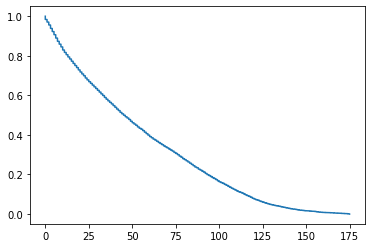

In [6]:
# number of cells expressing a gene more than exp_threshold 

# expression reads: 10
exp_threshold = 10
cells_by_gene = {}
for gene in exon_number_exp.index.get_level_values(0).unique():
    cells_by_gene[gene] = exon_number_exp.columns[exon_number_exp.loc[gene].sum(axis=0) >= exp_threshold]
ncells_by_gene = {key: len(val) for key, val in cells_by_gene.items()}

# number of genes expressed by more than 70 cells
a = pd.Series(ncells_by_gene)
a.sort_values(ascending=False, inplace=True)
(a >= 90).mean() * 20000

# cumulative plot
x = np.sort(list(ncells_by_gene.values()))
y = 1.0 - np.linspace(0, 1, len(x))
plt.plot(x, y)

## filter cells with low percentage of mitochondrial reads

In [5]:
live_cells = ['1-1_C3_S1',
 '1-1_H3_S6',
 '1-1_I3_S7',
 '1-1_J3_S8',
 '1-1_K3_S9',
 '1-1_L3_S10',
 '1-1_M3_S11',
 '1-2_N3_S12',
 '1-2_O3_S13',
 '1-2_E4_S16',
 '1-2_F4_S17',
 '1-2_H4_S19',
 '1-2_J4_S21',
 '1-2_K4_S22',
 '1-2_L4_S23',
 '1-2_M4_S24',
 '1-2_C5_S27',
 '1-2_D5_S28',
 '1-2_E5_S29',
 '1-2_F5_S30',
 '1-2_K5_S35',
 '1-2_L5_S36',
 '1-2_M5_S37',
 '1-2_N5_S38',
 '1-2_O5_S39',
 '1-2_C6_S40',
 '1-2_E6_S42',
 '1-2_F6_S43',
 '1-2_G6_S44',
 '1-2_H6_S45',
 '1-2_I6_S46',
 '1-2_J6_S47',
 '1-2_K6_S48',
 '1-1_M6_S50',
 '1-1_N6_S51',
 '1-1_O6_S52',
 '2-1_D7_S54',
 '2-1_F12_S121',
 '3-1_F3_S4',
 '3-1_G3_S5',
 '3-1_I3_S7',
 '3-1_J3_S8',
 '3-1_L3_S10',
 '3-1_M3_S11',
 '3-1_G4_S17',
 '3-1_H4_S18',
 '3-1_I4_S19',
 '3-1_J4_S20',
 '3-1_K4_S21',
 '3-1_L4_S22',
 '3-1_M4_S23',
 '3-1_N4_S24',
 '3-1_D5_S26',
 '3-1_G5_S29',
 '3-1_H5_S30',
 '3-1_I5_S31',
 '3-1_J5_S32',
 '3-1_K5_S33',
 '3-1_C6_S37',
 '3-1_D6_S38',
 '3-1_E6_S39',
 '3-1_F6_S40',
 '3-1_G6_S41',
 '3-1_H6_S42',
 '3-1_J6_S44',
 '3-1_K6_S45',
 '3-1_L6_S46',
 '3-1_M6_S47',
 '3-1_N6_S48',
 '3-1_D7_S50',
 '3-1_F7_S52',
 '3-1_G7_S53',
 '3-1_H7_S54',
 '3-1_I7_S55',
 '3-1_J7_S56',
 '3-1_K7_S57',
 '3-1_L7_S58',
 '3-1_M7_S59',
 '3-1_N7_S60',
 '3-1_C8_S61',
 '3-1_E8_S63',
 '3-1_F8_S64',
 '3-1_G8_S65',
 '3-1_I8_S67',
 '3-1_J8_S68',
 '3-1_K8_S69',
 '3-1_L8_S70',
 '3-1_C9_S73',
 '3-1_D9_S74',
 '3-1_E9_S75',
 '3-1_F9_S76',
 '3-1_G9_S77',
 '3-1_H9_S78',
 '3-1_I9_S79',
 '3-1_J9_S80',
 '3-1_K9_S81',
 '3-1_L9_S82',
 '3-1_E10_S87',
 '3-1_F10_S88',
 '3-1_G10_S89',
 '3-1_H10_S90',
 '3-1_J10_S92',
 '3-1_K10_S93',
 '3-1_L10_S94',
 '3-1_M10_S95',
 '3-1_N10_S96',
 '3-1_C11_S97',
 '3-1_D11_S98',
 '3-1_H11_S102',
 '3-1_E12_S111',
 '3-1_F12_S112',
 '3-1_G12_S113',
 '3-1_H12_S114',
 '3-1_I12_S115',
 '3-1_J12_S116',
 '3-1_K12_S117',
 '3-1_L12_S118',
 '3-1_M12_S119',
 '3-1_N12_S120']

In [139]:
# # genes that are not expressed by any cell
# no_exp_genes = gene_exp[live_cells][gene_exp[live_cells].sum(axis=1) == 0].index

# # genes with only one exon
# gene_1exon = [gene for gene in exon_number_exp[live_cells].index.get_level_values(0).unique() 
#                  if (exon_number_exp[live_cells].loc[gene].sum(axis=1) > 0).sum() == 1]

# generate included genes
icld_genes = set(exon_number_frac[live_cells].index.get_level_values(0).unique()) - (set(no_exp_genes) | set(gene_1exon))

# exclud these genes in exon_number_frac
exon_number_frac_live = exon_number_frac.loc[list(icld_genes)[1:]]
exon_number_frac_live.to_csv(save_figures + 'exon_number_frac_live_cells>=2exons.tsv', sep='\t')

In [140]:
def spearman_nD(x, y):
    '''
    x: (39466, 10) number of genes, number of cells
    y: (2, 10) number of features, number of cells
    
    '''
    from scipy.stats import rankdata
    xw = np.zeros(x.shape, float)
    for ii, xi in enumerate(x):
        xw[ii] = rankdata(xi, method='average')
    yw = np.zeros(y.shape, float)
    for ii, yi in enumerate(y):
        yw[ii] = rankdata(yi, method='average')

    xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
    yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
    n = xw.shape[1]
    r = np.dot(xw, yw.T) / n
    
    return r

In [141]:
exp_threshold = 10

feas = ['area']
phe = adata[live_cells, :].obs[feas]
exon_fracs = exon_number_frac_live.copy()

res = pd.DataFrame()
for gene in exon_fracs.index.get_level_values(0).unique():
    g_idx = (gene_exp[live_cells].loc[gene] >= exp_threshold) 
    
    x = exon_fracs.loc[gene][g_idx.index[g_idx]]
    y = phe[g_idx]
    r = spearman_nD(x.values, y.values.T)
    
    corr = pd.DataFrame(
                data=r,
                columns=phe.columns,
                dtype=float)

    corr['gene_name'] = gene
    corr['exon_number'] = exon_fracs.loc[gene].index
    corr['n_cell_gene'] = g_idx.sum()
    
    res = pd.concat([res, corr])
    
res.to_csv(save_figures + 'corr_area_exon_usage_omit_na_exp10.tsv', sep='\t')

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
<ipython-input-140-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-140-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-140-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-140-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-140-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) 

<ipython-input-140-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-140-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-140-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-140-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-140-256533739316>:15: RuntimeWarning: Mean of empty slice.
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freed

<ipython-input-140-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-140-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-140-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-140-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-140-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-140-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-140-256533739316>:15: RuntimeWarning: Mean of empty slice.
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(ax

<ipython-input-140-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-140-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-140-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-140-256533739316>:15: RuntimeWarning: Mean of empty slice.
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/

<ipython-input-140-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-140-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-140-256533739316>:15: RuntimeWarning: Mean of empty slice.
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/

<ipython-input-140-256533739316>:15: RuntimeWarning: Mean of empty slice.
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:251: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
<ipython-input-140-256533739316>:16: RuntimeWarning: Mean of empty slice.
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<

<ipython-input-140-256533739316>:15: RuntimeWarning: Mean of empty slice.
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:251: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
<ipython-input-140-256533739316>:16: RuntimeWarning: Mean of empty slice.
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<

<ipython-input-140-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-140-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-140-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-140-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-140-256533739316>:15: RuntimeWarning: Mean of empty slice.
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freed

<ipython-input-140-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-140-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-140-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-140-256533739316>:15: RuntimeWarning: Mean of empty slice.
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/

<ipython-input-140-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-140-256533739316>:15: RuntimeWarning: Mean of empty slice.
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:251: RuntimeWarning: invalid value encountered in true_divide
  ret

<ipython-input-140-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-140-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-140-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-140-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-140-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-140-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-140-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(

<ipython-input-140-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-140-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-140-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-140-256533739316>:15: RuntimeWarning: Mean of empty slice.
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/

<ipython-input-140-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-140-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-140-256533739316>:15: RuntimeWarning: invalid value encountered in true_divide
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
<ipython-input-140-256533739316>:16: RuntimeWarning: invalid value encountered in true_divide
  yw = ((yw.T - yw.mean(axis=1)) / yw.std(axis=1)).T
<ipython-input-140-256533739316>:15: RuntimeWarning: Mean of empty slice.
  xw = ((xw.T - xw.mean(axis=1)) / xw.std(axis=1)).T
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freed

In [21]:
def plot_bin_exons(adata, number_fra, corr, gene, exon_ns, bin_n, cmaps, xlabel, filetype, path=False):
    # create dataframe
    area_order = adata.obs['area'].sort_values().index
    df = number_fra.loc[gene].loc[exon_ns].T.loc[area_order] * 100
    df['order'] = '0'
    for i in range(bin_n):
        n = round(df.shape[0] / bin_n)
        idx = [j for j in np.arange(n) + n * i if j < df.shape[0]]
        df.loc[area_order[idx], 'order'] = 'Group {}'.format(str(i + 1))

    # plot boxplots
    rcParams['pdf.fonttype'] = 42
    rcParams['font.size'] = 10
    fig, axs = plt.subplots(1, len(exon_ns), figsize=[6, 2.5], sharex=True, sharey=True)
    plt.subplots_adjust(wspace=0.05)
    
    PROPS = {
        'boxprops':{'edgecolor':'white'},
        'medianprops':{'color':'white'},
        'whiskerprops':{'color':'none'},
        'capprops':{'color':'none'}}
        
    name = gene
    bins = np.array_split(adata.obs[fea].sort_values().array, 8)
    round_n = [0, 2]['.' in str(bins[0])]
    xticklabels = [f'{f"%.{round_n}f" % (i.min())}-{f"%.{round_n}f" % (i.max())}' for i in bins]
        
    for i, (n, cmap) in enumerate(zip(exon_ns, cmaps)):

        med = [df[df['order'] == 'Group {}'.format(str(i + 1))][n].median()
           for i in range(bin_n)]
        alpha = [0.2 + 0.6 * i/max(med) for i in med]
        cmap = mpl.cm.get_cmap(cmap)
        palette = [cmap(i) for i in alpha]

        sns.boxplot(data=df, x='order', y=n, palette=palette, ax=axs[i], **PROPS)
        sns.stripplot(data=df, x='order', y=n, palette=palette, edgecolor='white', 
                      linewidth=1, ax=axs[i], size=3)

        axs[i].set_xticklabels(xticklabels, rotation=90)
        axs[i].set_xlabel(xlabel)
        axs[i].set_ylabel(None)
        axs[i].set_title('{}: exon {}'.format(gene, str(n)))
        
        name += str(n)
        rho = corr.set_index(['gene_name', 'exon_number']).loc[gene, n]['area']
        axs[i].text(0.5, axs[i].get_yticks()[-3], r'$\rho$={}'.format(round(rho, 2)))
        
#     fig.text(0.5, 0.05, '{} of cells: smallest → largest'.format(fea.title()), va='center', ha='center')
    fig.text(0.05, 0.5, 'Frac of exon exp/gene exp [%]', va='center', ha='center', rotation=90)

    if path is not False:
        fig.savefig(os.path.join(path, name+filetype), dpi=300, bbox_inches='tight')
        
    return {'fig': fig, 'axs': axs}

In [15]:
number_fra_live = pd.read_csv(save_figures + 'exon_number_frac_live_cells>=2exons.tsv', 
                         sep='\t', index_col=['gene_name', 'exon_number'])
res = pd.read_csv(save_figures + 'corr_area_exon_usage_omit_na_exp10.tsv', sep='\t',)

/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
<ipython-input-21-fa70b8f5a927>:32: RuntimeWarning: invalid value encountered in double_scalars
  alpha = [0.2 + 0.6 * i/max(med) for i in med]
/home/yike/.conda/envs/scanpy/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)
<ipython-input-21-fa70b8f5a927>:32: RuntimeWarning: invalid value encountered in double_scalars
  alpha = [0.2 + 0.6 * i/max(med) for i in med]


{'fig': <Figure size 432x180 with 3 Axes>,
 'axs': array([<AxesSubplot: title={'center': 'DAAM1: exon 25'}, xlabel='Area [# px]'>,
        <AxesSubplot: title={'center': 'DAAM1: exon 11'}, xlabel='Area [# px]'>,
        <AxesSubplot: title={'center': 'DAAM1: exon 1'}, xlabel='Area [# px]'>],
       dtype=object)}

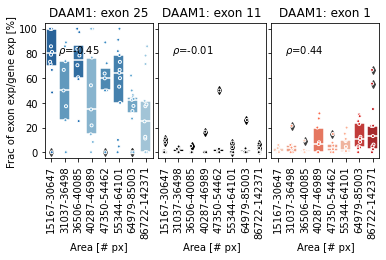

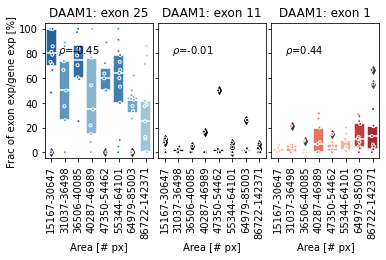

In [22]:
import matplotlib as mpl

fea = 'area'
gene = 'DAAM1'
exon_ns = [25, 11, 1]
bin_n = 8
cmaps = ['Blues', 'Greys', 'Reds']
path = save_figures

plot_bin_exons(adata[live_cells, ], number_fra_live, res, gene, exon_ns, 
               bin_n, cmaps, 'Area [# px]', '.png', path=save_figures)
plot_bin_exons(adata[live_cells, ], number_fra_live, res, gene, exon_ns, 
               bin_n, cmaps, 'Area [# px]', '.pdf', path=save_figures)

In [151]:
exon_corr = res.set_index(['gene_name', 'exon_number'])
exon_corr.loc['DAAM1']

,area,n_cell_gene
exon_number,,
1,0.443324,76
10,0.090094,76
11,-0.013776,76
12,0.042764,76
2,0.429532,76
22,0.020707,76
23,-0.056068,76
24,-0.128958,76
25,-0.451596,76
